----------------------------------------------------

## Title: Anomaly Detection in Credit Card Fraud Data Using Autoencoders

### Background
Credit card fraud is a significant issue in the financial industry, leading to substantial losses for both consumers and businesses. As online transactions increase, the need for effective fraud detection systems becomes more critical. Traditional methods often struggle to keep up with the rapidly evolving tactics of fraudsters. Therefore, leveraging advanced machine learning techniques such as Autoencoders (AEs) for anomaly detection offers a promising solution.

### Objective
The objective of this exercise is to `detect anomalies` in credit card transaction data, specifically `distinguishing` fraudulent transactions from normal ones. 

By using `Autoencoders`, we aim to learn a compressed representation of normal transaction data and identify deviations from this learned representation that indicate potential fraud.

### Methodology
1. **Data Preprocessing**: 
   - Load and preprocess credit card transaction data, focusing on relevant features that can aid in anomaly detection.
   - `Normalize` the data to ensure that the Autoencoder can effectively learn the underlying patterns.

2. **Model Development**: 
   - Implement an Autoencoder model to learn the reconstruction of normal transactions.
   - Train the model on the `normal transaction data`, optimizing it to minimize reconstruction loss.

3. **Anomaly Detection**: 
   - `Evaluate` reconstruction losses on both normal and fraudulent transactions.
   - Use statistical measures (e.g., `Z-scores`, `KL Divergence`, `Jensen-Shannon Divergence`) to quantify the `differences` between `reconstruction losses` of `normal` and `fraudulent transactions`.

4. **Results Analysis**: 
   - Compare the distributions of reconstruction losses to `identify thresholds` for flagging fraudulent transactions.
   - Analyze the performance of the Autoencoder in detecting anomalies based on statistical significance tests and visualization techniques.

### Expected Outcomes
- Identification of distinct patterns in reconstruction loss between normal and fraudulent transactions.
- Establishment of a robust framework for anomaly detection using Autoencoders, with potential application in real-time fraud detection systems.
- Insights into the characteristics that differentiate fraudulent transactions from normal ones, aiding in the development of more effective fraud prevention strategies.

-------------------------------------------


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Input, Dense, ReLU
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

In [2]:
# Load the data
location = r'D:\AI-DATASETS\02-MISC-large\creditcard.csv'
df = pd.read_csv(location)

In [3]:
df.shape

(284807, 31)

In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
109595,71449.0,1.247621,-0.859664,0.951902,-0.773556,-1.331163,0.062574,-1.212627,0.245222,-0.586524,...,0.467483,1.230575,-0.097760,0.060982,0.299772,-0.037840,0.042874,0.014903,33.00,0
180655,124640.0,0.176531,1.004345,-0.637133,0.710441,1.525659,-0.715281,1.630097,-0.482871,-0.950957,...,0.271661,1.130186,-0.105191,-0.379223,-0.764404,-0.539401,0.354196,0.102683,28.56,0
173591,121550.0,2.068494,-0.700333,-0.732643,-0.290478,-0.784271,-0.699718,-0.515031,-0.219159,-0.031029,...,-0.275048,-0.151541,0.282470,1.117465,-0.096286,-0.718876,0.060564,-0.019307,28.60,0
160325,113234.0,-0.994435,0.030415,1.052186,-2.474606,-0.449681,0.119260,0.111276,0.191303,-0.592054,...,0.330998,1.119213,-0.098008,0.720479,0.081326,-0.213045,0.386856,0.234297,69.99,0
82392,59383.0,1.303287,1.023966,-3.187599,0.468391,3.353988,2.431416,0.184510,0.622721,-0.556254,...,-0.265551,-0.823366,-0.241908,0.674554,1.012236,-0.278656,0.041260,0.089912,1.00,0


In [5]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
# Separate into normal and fraud transactions
df_normal = df[df['Class'] == 0].copy()
df_fraud  = df[df['Class'] == 1].copy()

In [8]:
# Standardize 'Time' and 'Amount' columns
scaler = StandardScaler()
df_normal['Time']   = scaler.fit_transform(df_normal['Time'].values.reshape(-1, 1))
df_normal['Amount'] = scaler.fit_transform(df_normal['Amount'].values.reshape(-1, 1))

df_fraud['Time']    = scaler.transform(df_fraud['Time'].values.reshape(-1, 1))
df_fraud['Amount']  = scaler.transform(df_fraud['Amount'].values.reshape(-1, 1))

In [9]:
# Drop the target column for training
X_normal = df_normal.drop(columns=['Class'])
X_fraud  = df_fraud.drop(columns=['Class'])

#### Build the AE model

In [10]:
import tensorflow as tf

In [11]:
# Define dimensions
input_dim  = X_normal.shape[1]
latent_dim = 7  # Adjust as necessary

input_dim, latent_dim

(30, 7)

In [12]:
# Encoder
encoder_input = Input(shape=(input_dim,), name="encoder_input")

encoder_dense_layer1 = Dense(units=14, name="encoder_dense_1")(encoder_input)
encoder_activ_layer1 = ReLU(name="encoder_relu_1")(encoder_dense_layer1)

encoder_dense_layer2 = Dense(units=latent_dim, name="encoder_dense_2")(encoder_activ_layer1)
encoder_output = ReLU(name="encoder_output")(encoder_dense_layer2)

encoder = Model(encoder_input, encoder_output, name="encoder_model")

In [13]:
# Decoder
decoder_input = Input(shape=(latent_dim,), name="decoder_input")

decoder_dense_layer1 = Dense(units=14, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = ReLU(name="decoder_relu_1")(decoder_dense_layer1)

decoder_dense_layer2 = Dense(units=input_dim, name="decoder_dense_2")(decoder_activ_layer1)
decoder_output = ReLU(name="decoder_output")(decoder_dense_layer2)

decoder = Model(decoder_input, decoder_output, name="decoder_model")

In [14]:
# Autoencoder
ae_input = Input(shape=(input_dim,), name="AE_input")

ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = Model(ae_input, ae_decoder_output, name="Autoencoder")

In [15]:
# Compile the autoencoder
ae.compile(optimizer = 'adam', 
           loss      = 'mean_squared_error', 
           metrics   = ['mse'])

#### Train the autoencoder

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor              = 'val_loss',   # Monitor validation loss
    patience             = 5,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights = True          # Restore the best weights after stopping
)

In [18]:
# Train the autoencoder on normal transactions with early stopping
history = ae.fit(
    X_normal, 
    X_normal,
    epochs          = 50,
    batch_size      = 256,
    shuffle         = True,
    validation_split= 0.1,
    callbacks       = [early_stopping]
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9597 - mse: 0.9597 - val_loss: 0.7871 - val_mse: 0.7871
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8005 - mse: 0.8005 - val_loss: 0.7602 - val_mse: 0.7602
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7782 - mse: 0.7782 - val_loss: 0.7516 - val_mse: 0.7516
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7625 - mse: 0.7625 - val_loss: 0.7511 - val_mse: 0.7511
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7669 - mse: 0.7669 - val_loss: 0.7461 - val_mse: 0.7461
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7595 - mse: 0.7595 - val_loss: 0.7438 - val_mse: 0.7438
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7638 - mse: 0.7638 - val_loss: 0.7445 - val_mse: 0.7445
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7536 - mse: 0.7536 - val_loss: 0.7428 - val_mse: 0.7428
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━

**Observe the training process**

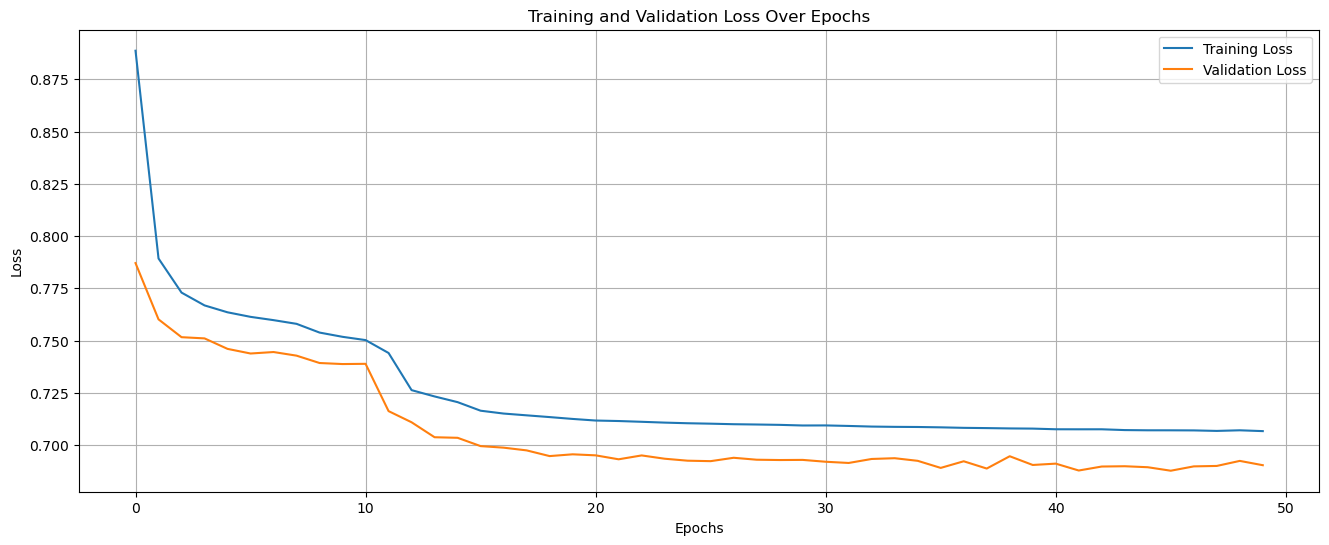

In [19]:
# Extract loss values from the training history
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(16, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss,   label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

#### Evaluate the reconstruction loss

- compare the recons loss of normal vs the fraud data

In [20]:
reconstructions_normal = ae.predict(X_normal)

8885/8885 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [22]:
reconstructions_normal.shape

(284315, 30)

In [23]:
reconstructions_normal

array([[0.        , 0.        , 0.17128867, ..., 0.        , 0.        ,
        0.02358982],
       [0.        , 0.8933398 , 0.02494851, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.1882346 ],
       ...,
       [1.2322226 , 2.327904  , 0.12912437, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.7321183 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.5191331 ]], dtype=float32)

In [26]:
reconstructions_loss_normal = np.mean(np.square(reconstructions_normal - X_normal), axis=1)

In [27]:
reconstructions_loss_normal                     # dist 1

0          0.340856
1          0.243233
2          0.978748
3          0.507982
4          0.336457
            ...    
284802    11.530521
284803     0.536304
284804     0.448088
284805     0.470821
284806     0.279736
Length: 284315, dtype: float64

In [29]:
reconstructions_fruad = ae.predict(X_fraud)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [30]:
reconstructions_fruad

array([[  0.       ,   0.       ,   1.9219881, ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   1.1820123],
       [  2.6537075,   0.       ,   3.116521 , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [104.08782  ,   0.       ,  42.150352 , ...,  12.673678 ,
        103.27438  ,   0.       ],
       [104.93028  ,   0.       ,  41.28094  , ...,  13.038336 ,
        104.04451  ,   0.       ],
       [106.70566  ,   0.       ,  43.40187  , ...,  10.682687 ,
        104.75326  ,   0.       ]], dtype=float32)

In [31]:
reconstructions_loss_fraud = np.mean(np.square(reconstructions_fruad - X_fraud), axis=1)

In [32]:
reconstructions_loss_fraud             # dist 2

541           3.367625
623           1.222888
4920         11.330514
6108         39.017867
6329         22.885223
              ...     
279863    12094.120452
280143    12074.277076
280149    12129.401488
281144    12225.978608
281674    12192.742139
Length: 492, dtype: float64

#### Ways to analyze the distributions

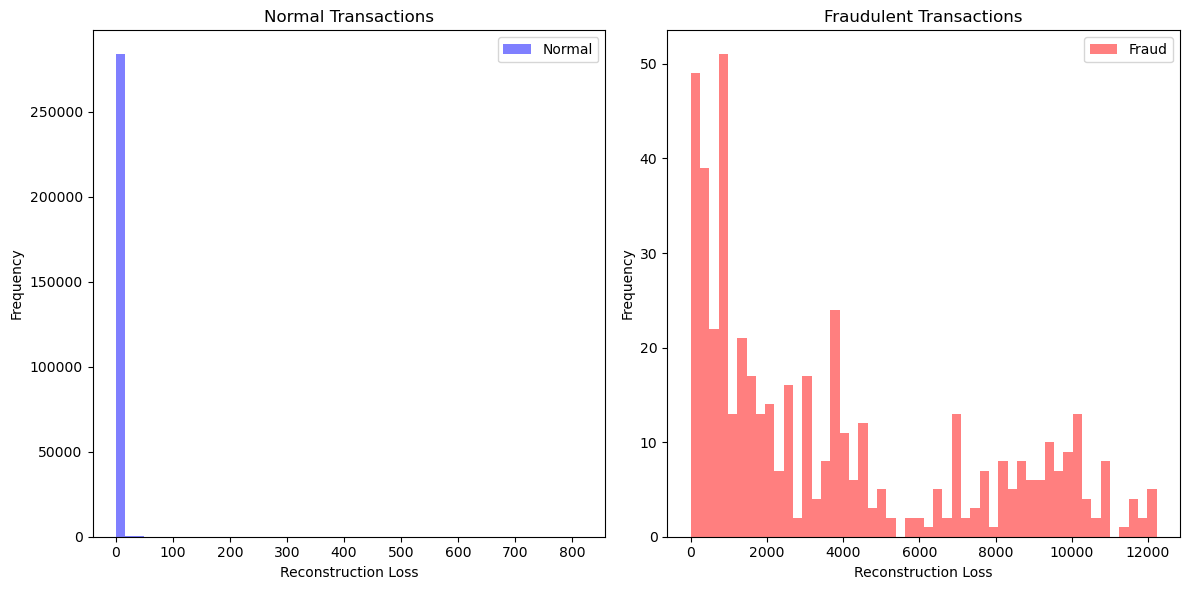

In [34]:
# Plot histograms in two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for normal transaction reconstruction loss
axes[0].hist(reconstructions_loss_normal, bins=50, alpha=0.5, color="blue", label="Normal")
axes[0].set_title("Normal Transactions")
axes[0].set_xlabel("Reconstruction Loss")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Histogram for fraudulent transaction reconstruction loss
axes[1].hist(reconstructions_loss_fraud, bins=50, alpha=0.5, color="red", label="Fraud")
axes[1].set_title("Fraudulent Transactions")
axes[1].set_xlabel("Reconstruction Loss")
axes[1].set_ylabel("Frequency")
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### mean and std dev

In [35]:
# Calculate mean and standard deviation for normal transactions
mean_normal = np.mean(reconstructions_loss_normal)
std_normal = np.std(reconstructions_loss_normal)

# Calculate mean and standard deviation for fraudulent transactions
mean_fraud = np.mean(reconstructions_loss_fraud)
std_fraud = np.std(reconstructions_loss_fraud)

# Display the results
print("Reconstruction Loss - Normal Transactions:")
print(f"Mean: {mean_normal:.4f}")
print(f"Standard Deviation: {std_normal:.4f}\n")

print("Reconstruction Loss - Fraudulent Transactions:")
print(f"Mean: {mean_fraud:.4f}")
print(f"Standard Deviation: {std_fraud:.4f}")

Reconstruction Loss - Normal Transactions:
Mean: 0.7047
Standard Deviation: 3.0891

Reconstruction Loss - Fraudulent Transactions:
Mean: 3752.3926
Standard Deviation: 3585.0027


#### box plot

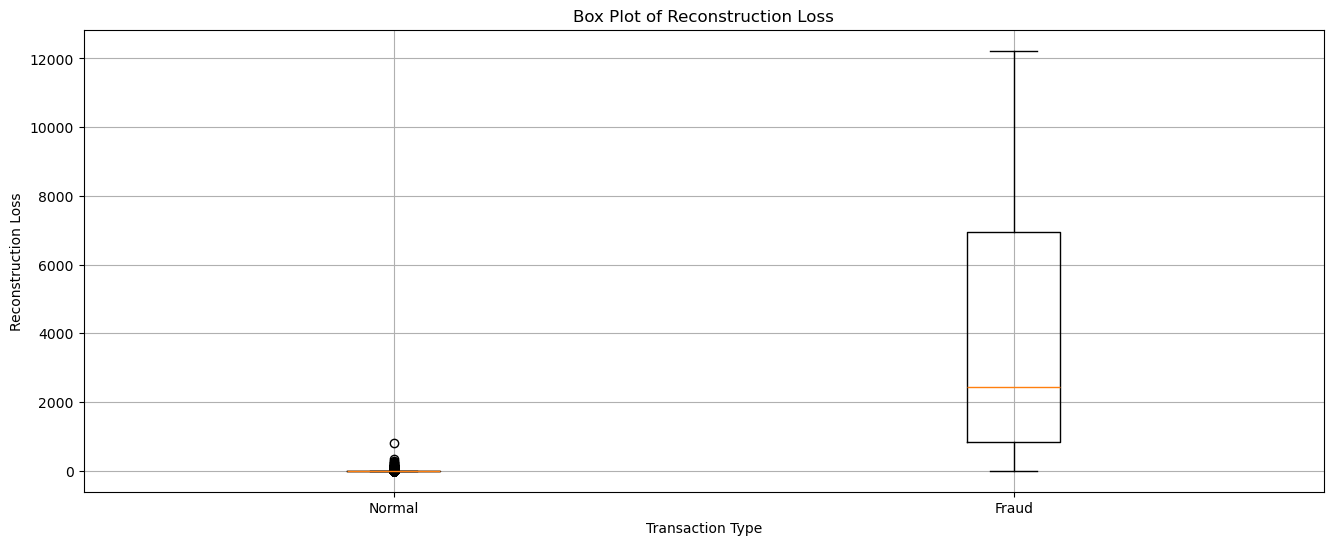

In [36]:
# Combine the reconstruction loss data for normal and fraud into a list
data = [reconstructions_loss_normal, reconstructions_loss_fraud]

# Plot the box plots with updated parameter name
plt.figure(figsize=(16, 6))
plt.boxplot(data, tick_labels=["Normal", "Fraud"], showfliers=True)
plt.title("Box Plot of Reconstruction Loss")
plt.ylabel("Reconstruction Loss")
plt.xlabel("Transaction Type")
plt.grid()
# Show plot
plt.show()

#### KDE (Kernel density estimation)

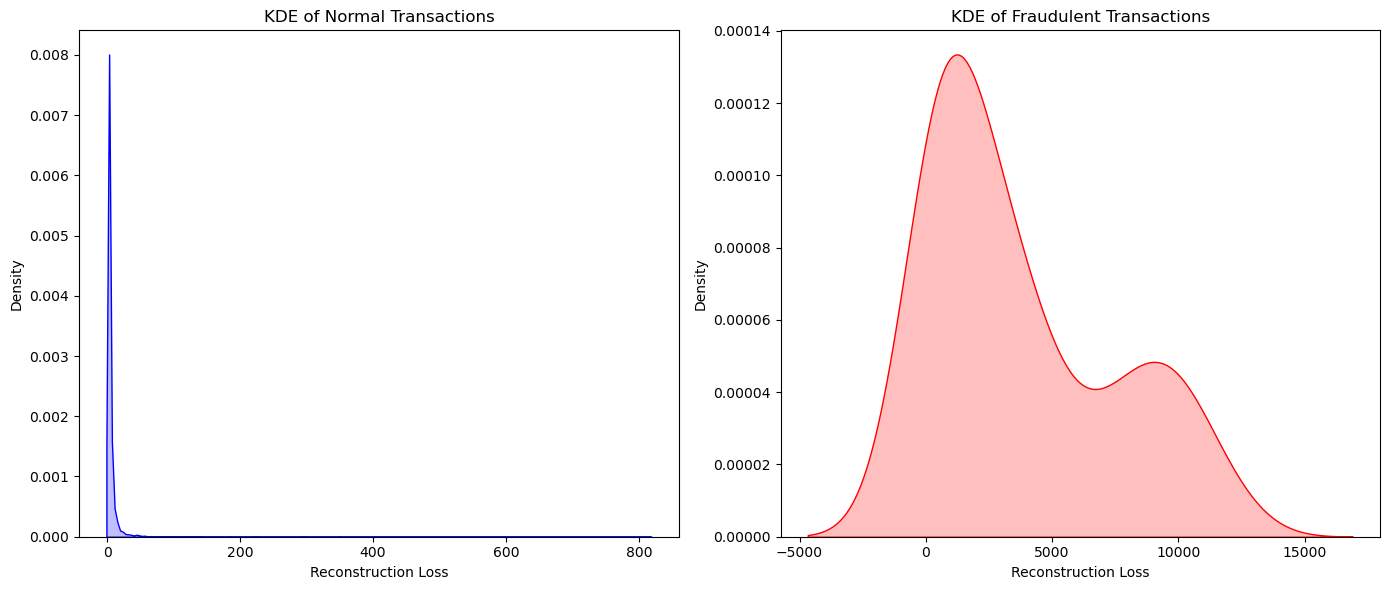

In [37]:
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# KDE plot for normal reconstruction loss
sns.kdeplot(reconstructions_loss_normal, ax=axes[0], color="blue", fill=True, bw_adjust=1.5)
axes[0].set_title("KDE of Normal Transactions")
axes[0].set_xlabel("Reconstruction Loss")
axes[0].set_ylabel("Density")

# KDE plot for fraud reconstruction loss
sns.kdeplot(reconstructions_loss_fraud, ax=axes[1], color="red", fill=True, bw_adjust=1.5)
axes[1].set_title("KDE of Fraudulent Transactions")
axes[1].set_xlabel("Reconstruction Loss")
axes[1].set_ylabel("Density")

# Show the plots
plt.tight_layout()
plt.show()

#### compute the Z-score of fraud vis-avis the normal

In [38]:
# Calculate mean and standard deviation of normal reconstruction losses
mean_normal = np.mean(reconstructions_loss_normal)
std_normal  = np.std(reconstructions_loss_normal)

# Calculate Z-scores for fraudulent reconstruction losses
z_scores_fraud = (reconstructions_loss_fraud - mean_normal) / std_normal

# Display Z-scores
print("Z-Scores of Reconstruction Loss for Fraudulent Transactions:")
print(z_scores_fraud)

Z-Scores of Reconstruction Loss for Fraudulent Transactions:
541          0.862035
623          0.167744
4920         3.439768
6108        12.402673
6329         7.180240
             ...     
279863    3914.860775
280143    3908.437110
280149    3926.281894
281144    3957.545682
281674    3946.786427
Length: 492, dtype: float64


if the loss for fraud and loss for normal are same then what would the Z-scores?

In [39]:
# Count the number of fraud samples with Z-score greater than 3
threshold = 3
count_fraud_outliers = np.sum(z_scores_fraud > threshold)

print(f"Number of fraudulent samples with Z-score greater than {threshold} standard deviations: {count_fraud_outliers}")

Number of fraudulent samples with Z-score greater than 3 standard deviations: 490


#### Quantile comparision

In [41]:
# Assuming reconstruction_loss_normal and reconstruction_loss_fraud are already defined
# Calculate the desired quantiles
quantiles = [0.25, 0.50, 0.75, 0.90]

# Create a DataFrame to hold the results
quantile_comparison = pd.DataFrame({
    'Quantile': quantiles,
    'Normal':   np.quantile(reconstructions_loss_normal, quantiles),
    'Fraud':    np.quantile(reconstructions_loss_fraud, quantiles)
})

# Display the quantile comparison
quantile_comparison

,Quantile,Normal,Fraud
0,0.25,0.248710,824.431012
1,0.50,0.389786,2434.530679
2,0.75,0.638754,6963.455743
3,0.90,1.021475,9775.652149


#### use the CDF of the 2 dist

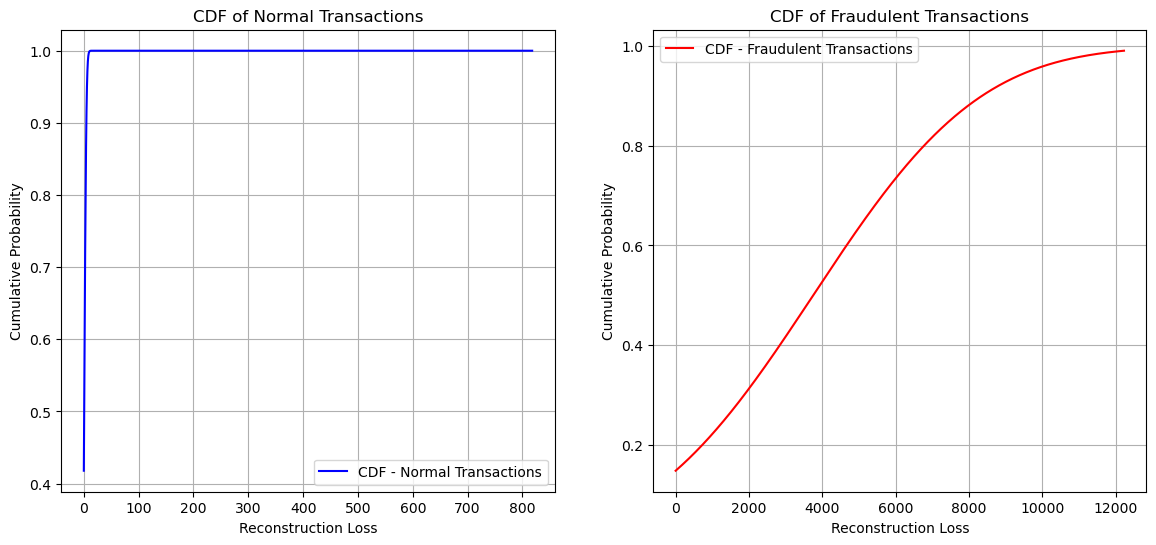

In [44]:
from scipy import stats

# Create a range of values for the CDF
x_normal = np.linspace(min(reconstructions_loss_normal), max(reconstructions_loss_normal), 1000)
x_fraud  = np.linspace(min(reconstructions_loss_fraud),  max(reconstructions_loss_fraud), 1000)

# Calculate the CDF using scipy.stats
cdf_normal = stats.norm.cdf(x_normal, loc=np.mean(reconstructions_loss_normal), scale=np.std(reconstructions_loss_normal))
cdf_fraud  = stats.norm.cdf(x_fraud,  loc=np.mean(reconstructions_loss_fraud),  scale=np.std(reconstructions_loss_fraud))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot CDF for normal transactions
ax1.plot(x_normal, cdf_normal, label='CDF - Normal Transactions', color='blue')
ax1.set_title('CDF of Normal Transactions')
ax1.set_xlabel('Reconstruction Loss')
ax1.set_ylabel('Cumulative Probability')
ax1.legend()
ax1.grid()

# Plot CDF for fraudulent transactions
ax2.plot(x_fraud, cdf_fraud, label='CDF - Fraudulent Transactions', color='red')
ax2.set_title('CDF of Fraudulent Transactions')
ax2.set_xlabel('Reconstruction Loss')
ax2.set_ylabel('Cumulative Probability')
ax2.legend()
ax2.grid()

#### compare the dist using t-test or equivalent (for not normally dist data)

Normality check...

In [46]:
from scipy.stats import anderson

# Anderson-Darling Test
result_normal = anderson(reconstructions_loss_normal)
result_fraud  = anderson(reconstructions_loss_fraud)

print("Anderson-Darling Test Results for Normal Transactions:")
print(f"Statistic: {result_normal.statistic}, \nCritical Values: {result_normal.critical_values}, \nSignificance Levels: {result_normal.significance_level}")

print("\nAnderson-Darling Test Results for Fraudulent Transactions:")
print(f"Statistic: {result_fraud.statistic}, \nCritical Values: {result_fraud.critical_values}, \nSignificance Levels: {result_fraud.significance_level}")

Anderson-Darling Test Results for Normal Transactions:
Statistic: 79558.54291097337, 
Critical Values: [0.576 0.656 0.787 0.918 1.092], 
Significance Levels: [15.  10.   5.   2.5  1. ]

Anderson-Darling Test Results for Fraudulent Transactions:
Statistic: 26.350136330305872, 
Critical Values: [0.571 0.651 0.781 0.911 1.083], 
Significance Levels: [15.  10.   5.   2.5  1. ]


In [ ]:
Q-Q plot 

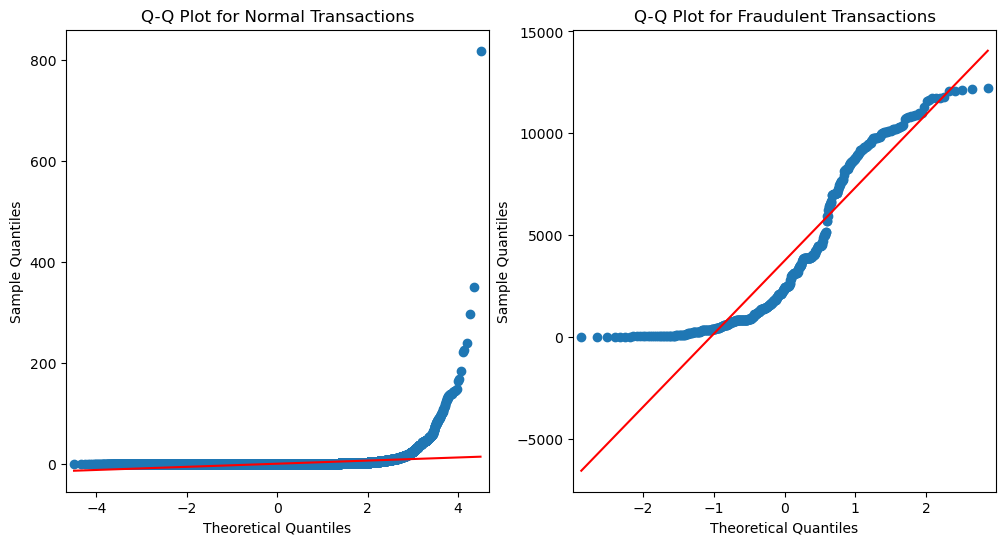

In [47]:
import statsmodels.api as sm

# Q-Q plot for Normal Transactions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sm.qqplot(reconstructions_loss_normal, line='s', ax=plt.gca())
plt.title('Q-Q Plot for Normal Transactions')

# Q-Q plot for Fraudulent Transactions
plt.subplot(1, 2, 2)
sm.qqplot(reconstructions_loss_fraud, line='s', ax=plt.gca())
plt.title('Q-Q Plot for Fraudulent Transactions')

plt.show()

We cannot use t-test 

but we can non-parameteric alternative (MANN-WHITNEY U TEST)

In [48]:
from scipy.stats import mannwhitneyu

# Mann-Whitney U Test
stat, p_value = mannwhitneyu(reconstructions_loss_normal, reconstructions_loss_fraud)

print(f"Mann-Whitney U Test Statistic: {stat}, p-value: {p_value}")

Mann-Whitney U Test Statistic: 32296.0, p-value: 0.0


Using KL divergence or JSD 
(used in VAE......RBM ... BM ... DALLE ....)